# playnomore crawling
- fake user agent 사용
    - `$ pip install fake_useragent scrapy-fake-useragent`
- argument 설정

In [1]:
!pip install fake_useragent scrapy-fake-useragent

     |████████████████████████████████| 1.1 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 3.5 MB/s eta 0:00:01


In [1]:
import scrapy
import requests

from scrapy.http import TextResponse
from fake_useragent import UserAgent

## 1. 프로젝트 생성

In [2]:
!scrapy startproject playnomore

Error: scrapy.cfg already exists in /Users/dokyum/Workspace/DSS - /TIL-data-science/scrapy/playnomore


## 2. xpath 확인
- item links data
- detail item data

In [1]:
# 링크 데이터 수집

In [3]:
ua = UserAgent().chrome

In [4]:
url = 'http://playnomore.co.kr/category/bag/24/'
headers = {'User-Agent' : ua}
req = requests.get(url, headers=headers)
req

<Response [200]>

In [5]:
response = TextResponse(req.url, body=req.text, encoding='utf-8')

In [6]:
links = response.xpath('//*[@id="contents"]/div[2]/div/ul/li/div/a/@href').extract()
links = list(map(response.urljoin, links))
len(links),links[0]

(15,
 'http://playnomore.co.kr/product/detail.html?product_no=136&cate_no=24&display_group=1')

In [16]:
# 상품 데이터 수집 : title, price, img_link

In [7]:
link = links[0]
req = requests.get(link, headers=headers)
response = TextResponse(req.url, body=req.text, encoding='utf-8')

In [8]:
title = response.xpath('//*[@id="contents"]/div[1]/div[1]/div[2]/div[1]/text()').extract()
title = ''.join(title).strip()
price = response.xpath('//*[@id="contents"]/div[1]/div[1]/div[2]/div[2]/text()').extract()[0]
img_link = 'http:' + response.xpath('//*[@id="contents"]/div[1]/div[1]/div[1]/div[1]/img/@src').extract()[0]
title, price, img_link

('[Refurb 50%] CHU black',
 '$ 165',
 'http://playnomore.co.kr/web/product/big/201803/136_shop7_507890.jpg')

## 3. items.py 코드 작성

In [ ]:
# %load playnomore/playnomore/items.py

In [9]:
%%writefile playnomore/playnomore/items.py
import scrapy


class PlaynomoreItem(scrapy.Item):
    title = scrapy.Field()
    price = scrapy.Field()
    img = scrapy.Field()
    link = scrapy.Field()
    pass

Overwriting playnomore/playnomore/items.py


## 4. spider.py 코드 작성
- fake user agent 사용

In [17]:
%%writefile playnomore/playnomore/spiders/spiders.py
import scrapy
from playnomore.items import PlaynomoreItem

class PlaynomoreSpider(scrapy.Spider):
    name = "Playnomore"
    custom_settings = {
        "DOWNLOADER_MIDDLEWARES" : {
            "scrapy.downloadermiddlewares.useragent.UserAgentMiddleware" : None,
            "scrapy_fake_useragent.middleware.RandomUserAgentMiddleware": 400,
        }
    }
    
    def start_requests(self):
        urls = ['http://playnomore.co.kr/category/bag/24/']
        for url in urls:
            yield scrapy.Request(url, callback=self.parse)
            
    def parse(self, response):
        links = response.xpath('//*[@id="contents"]/div[2]/div/ul/li/div/a/@href').extract()
        links = list(map(response.urljoin,links))
        for link in links:
            yield scrapy.Request(link, callback=self.parse_content)

    def parse_content(self, response):
        item = PlaynomoreItem()
        title = response.xpath('//*[@id="contents"]/div[1]/div[1]/div[2]/div[1]/text()').extract()
        item["title"] = ' '.join(title).strip()
        item["price"] = response.xpath('//*[@id="contents"]/div[1]/div[1]/div[2]/div[2]/text()').extract()[0]
        item["img"] = 'http:' + response.xpath('//*[@id="contents"]/div[1]/div[1]/div[1]/div[1]/img/@src').extract()[0]
        item["link"] = response.url
        yield item

Overwriting playnomore/playnomore/spiders/spiders.py


## 5. scrapy crawl

In [20]:
%%writefile run.sh
rm playnomore/items.csv
cd playnomore && scrapy crawl Playnomore -o items.csv

Overwriting run.sh


In [18]:
!/bin/bash run.sh

2021-01-06 14:04:32 [scrapy.utils.log] INFO: Scrapy 2.4.1 started (bot: playnomore)
2021-01-06 14:04:32 [scrapy.utils.log] INFO: Versions: lxml 4.5.2.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 20.3.0, Python 3.8.3 (default, Jul  2 2020, 11:26:31) - [Clang 10.0.0 ], pyOpenSSL 19.1.0 (OpenSSL 1.1.1g  21 Apr 2020), cryptography 2.9.2, Platform macOS-10.15.7-x86_64-i386-64bit
2021-01-06 14:04:32 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.selectreactor.SelectReactor
2021-01-06 14:04:32 [scrapy.crawler] INFO: Overridden settings:
{'BOT_NAME': 'playnomore',
 'NEWSPIDER_MODULE': 'playnomore.spiders',
 'ROBOTSTXT_OBEY': True,
 'SPIDER_MODULES': ['playnomore.spiders']}
2021-01-06 14:04:32 [scrapy.extensions.telnet] INFO: Telnet Password: 5370b8f6ad2a57e6
2021-01-06 14:04:32 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrap

2021-01-06 14:04:33 [scrapy.core.engine] DEBUG: Crawled (200) <GET http://playnomore.co.kr/product/bag-im-your-shystar-rose-gold/107/?cate_no=24&display_group=1> (referer: http://playnomore.co.kr/category/bag/24/)
2021-01-06 14:04:33 [scrapy.core.engine] DEBUG: Crawled (200) <GET http://playnomore.co.kr/product/bag-micro-candy-almond/535/?cate_no=24&display_group=1> (referer: http://playnomore.co.kr/category/bag/24/)
2021-01-06 14:04:33 [scrapy.core.scraper] DEBUG: Scraped from <200 http://playnomore.co.kr/product/refurb-50-barbie-bucketdeep-grey-453/110/?cate_no=24&display_group=1>
{'img': 'http://playnomore.co.kr/web/product/big/201612/110_shop7_268176.jpg',
 'link': 'http://playnomore.co.kr/product/refurb-50-barbie-bucketdeep-grey-453/110/?cate_no=24&display_group=1',
 'price': '$ 227',
 'title': '[Refurb 50%] BARBIE BUCKET deep grey'}
2021-01-06 14:04:33 [scrapy.core.scraper] DEBUG: Scraped from <200 http://playnomore.co.kr/product/bag-micro-candy-midnight/536/?cate_no=24&display_g

In [21]:
df = pd.read_csv('./playnomore/items.csv')
df.tail()

,img,link,price,title
10,http://playnomore.co.kr/web/product/big/202007...,http://playnomore.co.kr/product/bag-micro-cand...,$ 180,[BAG] MICRO CANDY lavender
11,http://playnomore.co.kr/web/product/big/202007...,http://playnomore.co.kr/product/bag-micro-cand...,$ 180,[BAG] MICRO CANDY powder blue (croc)
12,http://playnomore.co.kr/web/product/big/202007...,http://playnomore.co.kr/product/bag-micro-cand...,$ 180,[BAG] MICRO CANDY red
13,http://playnomore.co.kr/web/product/big/202007...,http://playnomore.co.kr/product/bag-micro-cand...,$ 180,[BAG] MICRO CANDY white
14,http://playnomore.co.kr/web/product/big/202007...,http://playnomore.co.kr/product/bag-micro-cand...,$ 180,[BAG] MICRO CANDY natural


## 6. 카테고리 설정 > 프로젝트 실행
- 카테고리 아규먼트 설정을 위한 spider.py 구조 변경

In [28]:
%%writefile playnomore/playnomore/spiders/spiders.py
import scrapy
from playnomore.items import PlaynomoreItem

class PlaynomoreSpider(scrapy.Spider):
    name = "Playnomore"
    custom_settings = {
        "DOWNLOADER_MIDDLEWARES" : {
            "scrapy.downloadermiddlewares.useragent.UserAgentMiddleware" : None,
            "scrapy_fake_useragent.middleware.RandomUserAgentMiddleware": 400,
        }
    }
    
    def __init__(self, category1='bag', category2='24', **kwargs):
        self.start_urls = ["http://playnomore.co.kr/category/{}/{}/".format(category1, category2)]
        super().__init__(**kwargs)
        
    def start_requests(self):
        urls = self.start_urls
        for url in urls:
            yield scrapy.Request(url, callback=self.parse)
            
    def parse(self, response):
        links = response.xpath('//*[@id="contents"]/div[2]/div/ul/li/div/a/@href').extract()
        links = list(map(response.urljoin,links))
        for link in links:
            yield scrapy.Request(link, callback=self.parse_content)

    def parse_content(self, response):
        item = PlaynomoreItem()
        title = response.xpath('//*[@id="contents"]/div[1]/div[1]/div[2]/div[1]/text()').extract()
        item["title"] = ' '.join(title).strip()
        item["price"] = response.xpath('//*[@id="contents"]/div[1]/div[1]/div[2]/div[2]/text()').extract()[0]
        item["img"] = 'http:' + response.xpath('//*[@id="contents"]/div[1]/div[1]/div[1]/div[1]/img/@src').extract()[0]
        item["link"] = response.url
        yield item

Overwriting playnomore/playnomore/spiders/spiders.py


In [33]:
%%writefile run.sh
rm playnomore/items.csv
cd playnomore && scrapy crawl Playnomore -o items.csv -a category1='beauty' -a category2=28

Overwriting run.sh


In [34]:
!/bin/bash run.sh

2021-01-06 14:20:06 [scrapy.utils.log] INFO: Scrapy 2.4.1 started (bot: playnomore)
2021-01-06 14:20:06 [scrapy.utils.log] INFO: Versions: lxml 4.5.2.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 20.3.0, Python 3.8.3 (default, Jul  2 2020, 11:26:31) - [Clang 10.0.0 ], pyOpenSSL 19.1.0 (OpenSSL 1.1.1g  21 Apr 2020), cryptography 2.9.2, Platform macOS-10.15.7-x86_64-i386-64bit
2021-01-06 14:20:06 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.selectreactor.SelectReactor
2021-01-06 14:20:06 [scrapy.crawler] INFO: Overridden settings:
{'BOT_NAME': 'playnomore',
 'NEWSPIDER_MODULE': 'playnomore.spiders',
 'ROBOTSTXT_OBEY': True,
 'SPIDER_MODULES': ['playnomore.spiders']}
2021-01-06 14:20:06 [scrapy.extensions.telnet] INFO: Telnet Password: 990128123319bea9
2021-01-06 14:20:06 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrap

2021-01-06 14:20:11 [scrapy.core.scraper] DEBUG: Scraped from <200 http://playnomore.co.kr/product/nail-sticker-06-shygirl-eyes/188/?cate_no=28&display_group=1>
{'img': 'http://playnomore.co.kr/web/product/big/201702/188_shop7_538871.jpg',
 'link': 'http://playnomore.co.kr/product/nail-sticker-06-shygirl-eyes/188/?cate_no=28&display_group=1',
 'price': '$ 14',
 'title': '[NAIL STICKER]  06 SHYGIRL EYES'}
2021-01-06 14:20:11 [scrapy.core.scraper] DEBUG: Scraped from <200 http://playnomore.co.kr/product/nail-sticker-01-lip/183/?cate_no=28&display_group=1>
{'img': 'http://playnomore.co.kr/web/product/big/201702/183_shop7_955971.jpg',
 'link': 'http://playnomore.co.kr/product/nail-sticker-01-lip/183/?cate_no=28&display_group=1',
 'price': '$ 14',
 'title': '[NAIL STICKER]  01 LIP'}
2021-01-06 14:20:11 [scrapy.core.engine] DEBUG: Crawled (200) <GET http://playnomore.co.kr/product/nail-sticker-02-make-up-your-mind/185/?cate_no=28&display_group=1> (referer: http://playnomore.co.kr/category/be

In [35]:
df = pd.read_csv('./playnomore/items.csv')
df.tail()

,img,link,price,title
3,http://playnomore.co.kr/web/product/big/201701...,http://playnomore.co.kr/product/nail-sticker-0...,$ 14,[NAIL STICKER] 09 BLAH BLAH
4,http://playnomore.co.kr/web/product/big/201702...,http://playnomore.co.kr/product/nail-sticker-0...,$ 14,[NAIL STICKER] 04 PLAY_PINK
5,http://playnomore.co.kr/web/product/big/201702...,http://playnomore.co.kr/product/nail-sticker-0...,$ 14,[NAIL STICKER] 06 SHYGIRL EYES
6,http://playnomore.co.kr/web/product/big/201702...,http://playnomore.co.kr/product/nail-sticker-0...,$ 14,[NAIL STICKER] 01 LIP
7,http://playnomore.co.kr/web/product/big/201702...,http://playnomore.co.kr/product/nail-sticker-0...,$ 14,[NAIL STICKER] 02 MAKE UP YOUR MIND


## Image down

In [36]:
!mkdir imgs

In [43]:
for idx, data in df.iterrows():
    response = requests.get(data.img, headers=headers)
    with open("imgs/{}.jpg".format(idx), "wb") as f:
        f.write(response.content)

In [45]:
!ls -al imgs/

total 3944
drwxr-xr-x  10 dokyum  staff     320  1  6 14:28 .
drwxr-xr-x  13 dokyum  staff     416  1  6 14:29 ..
-rw-r--r--   1 dokyum  staff  333284  1  6 14:29 0.jpg
-rw-r--r--   1 dokyum  staff   68423  1  6 14:29 1.jpg
-rw-r--r--   1 dokyum  staff  332863  1  6 14:29 2.jpg
-rw-r--r--   1 dokyum  staff   70652  1  6 14:29 3.jpg
-rw-r--r--   1 dokyum  staff  270644  1  6 14:29 4.jpg
-rw-r--r--   1 dokyum  staff  298639  1  6 14:29 5.jpg
-rw-r--r--   1 dokyum  staff  293407  1  6 14:29 6.jpg
-rw-r--r--   1 dokyum  staff  332500  1  6 14:29 7.jpg


In [47]:
from PIL import Image as pil

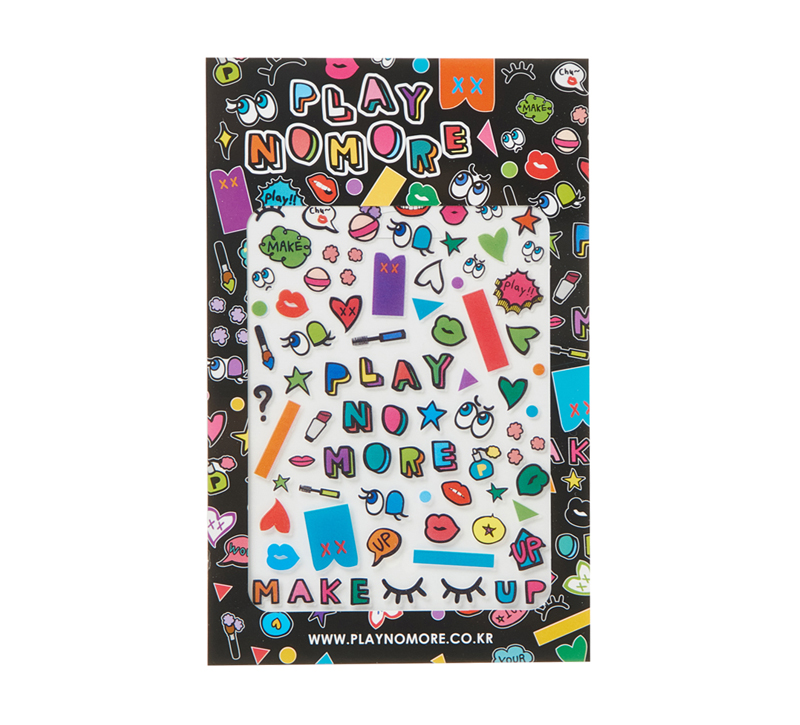

In [48]:
pil.open('imgs/0.jpg')